# Cell2TCR
First, install the package as described in https://github.com/Teichlab/cell2tcr and activate the environment.

In [1]:
import cell2tcr
import celltypist
import scanpy as sc
import pandas as pd

/home/jovyan/my-conda-envs/cell2tcr_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
path_data = '/nfs/team205/ld21/cell2tcr/data/'
path_figures = '/nfs/team205/ld21/cell2tcr/figures/'

## Download data
For the purpose of this tutorial, we will use the COMBAT dataset (https://doi.org/10.5281/zenodo.6120249). Download takes ~10min.

In a terminal, navigate into the `path_data` folder and run:

```wget https://zenodo.org/record/6120249/files/COMBAT-CITESeq-DATA.h5ad```

## Load and format data

In [3]:
adata = sc.read_h5ad(path_data+'COMBAT-CITESeq-DATA.h5ad')
adata

AnnData object with n_obs × n_vars = 836148 × 20807
    obs: 'Annotation_cluster_id', 'Annotation_cluster_name', 'Annotation_minor_subset', 'Annotation_major_subset', 'Annotation_cell_type', 'GEX_region', 'QC_ngenes', 'QC_total_UMI', 'QC_pct_mitochondrial', 'QC_scrub_doublet_scores', 'TCR_chain_composition', 'TCR_clone_ID', 'TCR_clone_count', 'TCR_clone_proportion', 'TCR_contains_unproductive', 'TCR_doublet', 'TCR_chain_TRA', 'TCR_v_gene_TRA', 'TCR_d_gene_TRA', 'TCR_j_gene_TRA', 'TCR_c_gene_TRA', 'TCR_productive_TRA', 'TCR_cdr3_TRA', 'TCR_umis_TRA', 'TCR_chain_TRA2', 'TCR_v_gene_TRA2', 'TCR_d_gene_TRA2', 'TCR_j_gene_TRA2', 'TCR_c_gene_TRA2', 'TCR_productive_TRA2', 'TCR_cdr3_TRA2', 'TCR_umis_TRA2', 'TCR_chain_TRB', 'TCR_v_gene_TRB', 'TCR_d_gene_TRB', 'TCR_j_gene_TRB', 'TCR_c_gene_TRB', 'TCR_productive_TRB', 'TCR_chain_TRB2', 'TCR_v_gene_TRB2', 'TCR_d_gene_TRB2', 'TCR_j_gene_TRB2', 'TCR_c_gene_TRB2', 'TCR_productive_TRB2', 'TCR_cdr3_TRB2', 'TCR_umis_TRB2', 'BCR_umis_HC', 'BCR_contig_qc_H

In [3]:
### in case of memory issues during QC / Celltypist prediction : save the T cell adata to file and load in new session ###

# subset to T cells
# adata = adata[adata.obs.TCR_chain_composition=='double_alpha_beta']

# save T cell adata
# adata.write_h5ad(path_data+'COMBAT_T_cells.h5ad', compression='gzip')

### restart kernel and load packages + paths ###

# load T cell data
# adata = sc.read_h5ad(path_data+'COMBAT_T_cells.h5ad')

## QC

In [4]:
adata.X = adata.layers['raw']
sc.pp.filter_cells(adata, min_genes=200)
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

## Celltypist prediction

In [5]:
# download newest Celltypist models - only required once
from celltypist import models
models.download_models(force_update = True)

📜 Retrieving model list from server https://celltypist.cog.sanger.ac.uk/models/models.json
📚 Total models in list: 19
📂 Storing models in /home/jovyan/.celltypist/data/models
💾 Downloading model [1/19]: Immune_All_Low.pkl
💾 Downloading model [2/19]: Immune_All_High.pkl
💾 Downloading model [3/19]: Adult_Mouse_Gut.pkl
💾 Downloading model [4/19]: Autopsy_COVID19_Lung.pkl
💾 Downloading model [5/19]: COVID19_HumanChallenge_Blood.pkl
💾 Downloading model [6/19]: COVID19_Immune_Landscape.pkl
💾 Downloading model [7/19]: Cells_Fetal_Lung.pkl
💾 Downloading model [8/19]: Cells_Intestinal_Tract.pkl
💾 Downloading model [9/19]: Cells_Lung_Airway.pkl
💾 Downloading model [10/19]: Developing_Human_Brain.pkl
💾 Downloading model [11/19]: Developing_Human_Thymus.pkl
💾 Downloading model [12/19]: Developing_Mouse_Brain.pkl
💾 Downloading model [13/19]: Healthy_COVID19_PBMC.pkl
💾 Downloading model [14/19]: Human_IPF_Lung.pkl
💾 Downloading model [15/19]: Human_Lung_Atlas.pkl
💾 Downloading model [16/19]: Human_P

In [6]:
predictions = celltypist.annotate(adata, model='COVID19_HumanChallenge_Blood.pkl')
adata = predictions.to_adata()
adata = adata[adata.obs.predicted_labels.str.contains('T ')]
adata

🔬 Input data has 287603 cells and 20807 genes
🔗 Matching reference genes in the model
🧬 4007 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!


View of AnnData object with n_obs × n_vars = 266051 × 20807
    obs: 'Annotation_cluster_id', 'Annotation_cluster_name', 'Annotation_minor_subset', 'Annotation_major_subset', 'Annotation_cell_type', 'GEX_region', 'QC_ngenes', 'QC_total_UMI', 'QC_pct_mitochondrial', 'QC_scrub_doublet_scores', 'TCR_chain_composition', 'TCR_clone_ID', 'TCR_clone_count', 'TCR_clone_proportion', 'TCR_contains_unproductive', 'TCR_doublet', 'TCR_chain_TRA', 'TCR_v_gene_TRA', 'TCR_d_gene_TRA', 'TCR_j_gene_TRA', 'TCR_c_gene_TRA', 'TCR_productive_TRA', 'TCR_cdr3_TRA', 'TCR_umis_TRA', 'TCR_chain_TRA2', 'TCR_v_gene_TRA2', 'TCR_d_gene_TRA2', 'TCR_j_gene_TRA2', 'TCR_c_gene_TRA2', 'TCR_productive_TRA2', 'TCR_cdr3_TRA2', 'TCR_umis_TRA2', 'TCR_chain_TRB', 'TCR_v_gene_TRB', 'TCR_d_gene_TRB', 'TCR_j_gene_TRB', 'TCR_c_gene_TRB', 'TCR_productive_TRB', 'TCR_chain_TRB2', 'TCR_v_gene_TRB2', 'TCR_d_gene_TRB2', 'TCR_j_gene_TRB2', 'TCR_c_gene_TRB2', 'TCR_productive_TRB2', 'TCR_cdr3_TRB2', 'TCR_umis_TRB2', 'BCR_umis_HC', 'BCR_con

activated,False,True
DiseaseClassification,,
COVID-19;MONDO:0100096,0.677148,0.872780
Influenza;MONDO:0005812,0.019395,0.018818
NA,0.136321,0.026239
Sepsis;HP:0100806,0.167136,0.082163


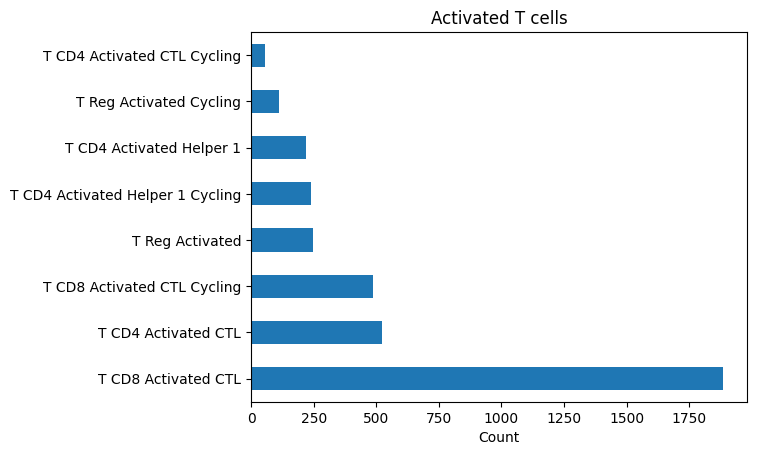

In [7]:
# mark activated T cells, ignoring MAIT cells
adata.obs['activated'] = adata.obs.predicted_labels.str.contains('Activated') & ~ adata.obs.predicted_labels.str.contains('MAI')

# visualise results
adata[adata.obs.activated].obs.predicted_labels.value_counts().plot.barh(title='Activated T cells', xlabel='Count')

# check that activated T cell numbers are high in COVID-19 and low in healthy (NA) 
pd.crosstab(adata.obs.DiseaseClassification, adata.obs.activated, normalize='columns')

## Subset to T cells of interest

In [8]:
# select activated T cells from COVID-19 patients
df = adata[(adata.obs.activated)&(adata.obs.DiseaseClassification=='COVID-19;MONDO:0100096')].obs.copy()

In [9]:
### If data is not yet in Scirpy format ###

# save CDR3 amino acid sequences as columns
df[['TCR_cdr3_TRA','TCR_cdr3_TRB']] = df.TCR_clone_ID.str.split('_|-', expand=True)[[1,3]]

# format to match Scirpy
for i, j in zip(
    ['individual', 'IR_VDJ_1_junction_aa','IR_VDJ_1_v_call','IR_VDJ_1_j_call','IR_VJ_1_junction_aa','IR_VJ_1_v_call','IR_VJ_1_j_call'], # Scirpy format - leave unchanged
    ['COMBAT_ID', 'TCR_cdr3_TRB','TCR_v_gene_TRB','TCR_j_gene_TRB','TCR_cdr3_TRA','TCR_v_gene_TRA','TCR_j_gene_TRA']): # your format - modify to match your column names
    df.loc[:,i] = df.loc[:,j].copy()

## Infer TCR motifs

In [11]:
cell2tcr.motifs(df, add_suffix=False) 

/home/jovyan/my-conda-envs/cell2tcr_env/lib/python3.10/site-packages/tcrdist/repertoire.py:792: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.cell_df['count'] = 1


In [10]:
### Troubleshooting errors with VDJ gene formats in 'cell2tcr.motifs'

# If your VDJ genes don't end in *01, *02, ... : Set 'add_suffix=True'

# Reduce chunk_size in case of memory errors

# if specific VDJ genes are missing : manually remove those cells, like this:
df = df[~df.IR_VDJ_1_v_call.isin(['TRBV24-1*02'])]
df = df[~df.IR_VJ_1_v_call.isin(['TRAV36/DV7*05','TRAV1-2*03','TRAV6*07','TRAV8-2*03','TRAV29/DV5*04','TRAV30*05',])]
df = df[~df.IR_VJ_1_j_call.isin(['TRAJ16*02','TRAJ24*03'])] # ... etc

# if errors persist : replace VDJ alleles with generic *01 suffix. Then run cell2tcr.motifs()
for gene in ['IR_VDJ_1_v_call','IR_VDJ_1_j_call','IR_VJ_1_v_call','IR_VJ_1_j_call']:
    df[gene] = df[gene].str.split('*', expand=True)[0]+'*01'

## Draw 10 most shared motifs

In [12]:
import matplotlib
matplotlib.rcParams['savefig.bbox'] = 'tight'

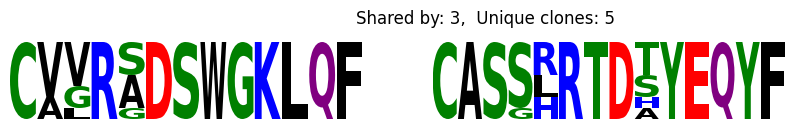

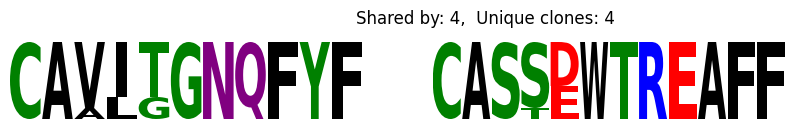

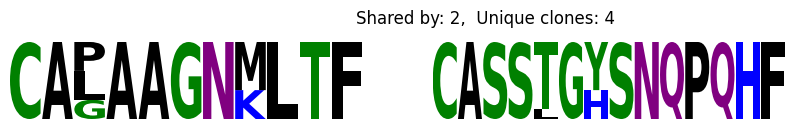

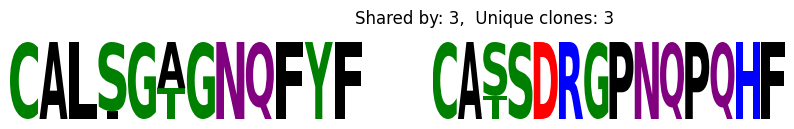

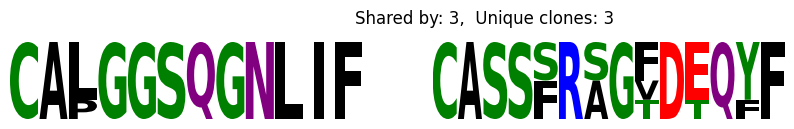

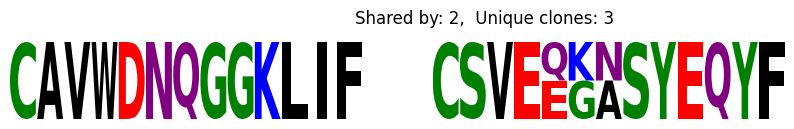

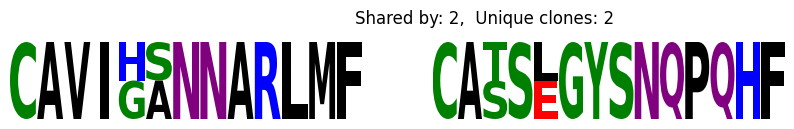

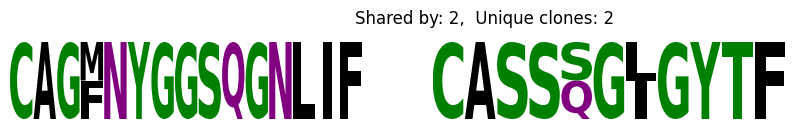

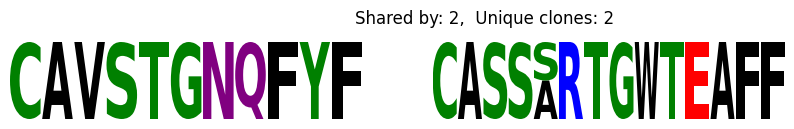

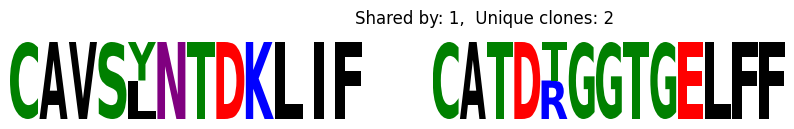

In [13]:
for i in range(10):
    cell2tcr.draw_cdr3(df[df.motif==i], savefig_title=path_figures+f'motif_{i}', put_title=True)

In [14]:
df.groupby('motif').nunique()

,Annotation_cluster_id,Annotation_cluster_name,Annotation_minor_subset,Annotation_major_subset,Annotation_cell_type,GEX_region,QC_ngenes,QC_total_UMI,QC_pct_mitochondrial,QC_scrub_doublet_scores,...,IR_VJ_1_v_call,IR_VJ_1_j_call,subject,cdr3_b_aa,v_b_gene,j_b_gene,cdr3_a_aa,v_a_gene,j_a_gene,clone_id
motif,,,,,,,,,,,,,,,,,,,,,
0,4,4,3,1,1,1,7,7,7,7,...,1,1,3,5,1,1,4,1,1,5
1,4,4,3,1,1,2,7,7,7,7,...,1,1,4,3,1,1,4,1,1,4
2,3,3,3,1,1,2,8,8,8,8,...,1,2,2,3,1,1,4,1,2,4
3,6,6,4,1,1,1,10,10,10,10,...,1,1,3,2,1,1,3,1,1,3
4,3,3,3,1,1,2,4,4,4,4,...,1,1,3,3,1,3,2,1,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2045,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2046,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2047,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
